In [1]:
%matplotlib inline

import xarray as xr
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, save
from bokeh.io import reset_output
import bokeh
import sys
import multiprocessing as mp
from collections import OrderedDict
import cartopy.crs as ccrs
import pickle
from scipy.stats import rankdata

from tonic.io import read_configobj
import timeit

from analysis_utils import (
    rmse, find_global_param_value, determine_tile_frac, get_soil_depth,
    setup_output_dirs, calculate_rmse, calculate_pbias)

In [11]:
# ========================================================== #
# Command line arguments
# ========================================================== #
# --- Load in config file --- #
cfg = read_configobj('/civil/hydro/ymao/data_assim/tools/plot_analyze_results/cfg/' \
                     '20180331.small_basins.synthetic/arkansas/sm_0.5.R_9.prec_0.3/' \
                     'plot.EnKF_results.cfg')

In [12]:
# ========================================================== #
# Parameter setting
# ========================================================== #

# --- Input directory and files --- #
# Ensemble prediction post-process results
post_result_basedir = cfg['POSTPROCESS']['post_result_basedir']

# Synthetic results basedir
gen_synth_basedir = cfg['EnKF']['gen_synth_basedir']
truth_nc_filename = cfg['EnKF']['truth_nc_filename']

# openloop
openloop_basedir = cfg['EnKF']['openloop_basedir']

# VIC global file template (for extracting param file and snow_band)
vic_global_txt = cfg['EnKF']['vic_global_txt']

# Domain netCDF file
domain_nc = cfg['EnKF']['domain_nc']

# Time period
start_time = pd.to_datetime(cfg['EnKF']['start_time'])
end_time = pd.to_datetime(cfg['EnKF']['end_time'])
start_year = start_time.year
end_year = end_time.year

# VIC parameter netCDF file
vic_param_nc = cfg['EnKF']['vic_param_nc']

# --- Measurement times --- #
meas_times = pd.date_range(
    cfg['EnKF']['meas_start_time'],
    cfg['EnKF']['meas_end_time'],
    freq=cfg['EnKF']['freq'])

# --- Plot time period --- #
plot_start_time = pd.to_datetime(cfg['EnKF']['plot_start_time'])
plot_end_time = pd.to_datetime(cfg['EnKF']['plot_end_time'])
plot_start_year = plot_start_time.year
plot_end_year = plot_end_time.year

# --- others --- #
N_state = cfg['EnKF']['N']  # ensemble size of state update
N_prec = cfg['SMART']['N']  # ensemble size of rainfall correction

# --- Output --- #
output_rootdir = cfg['OUTPUT']['output_post_dir']

In [13]:
# ========================================================== #
# Setup output data dir
# ========================================================== #
output_data_dir = setup_output_dirs(
        output_rootdir,
        mkdirs=['data'])['data']
output_maps_dir = setup_output_dirs(
                    output_rootdir,
                    mkdirs=['maps'])['maps']
output_ts_dir = setup_output_dirs(
        output_rootdir,
        mkdirs=['time_series'])['time_series']

In [14]:
# ========================================================== #
# Load data
# ========================================================== #
print('Loading data...')

# --- Domain --- #
da_domain = xr.open_dataset(domain_nc)['mask']

# --- Tile fraction --- #
da_tile_frac = determine_tile_frac(vic_global_txt)  # [veg_class, snow_band, lat, lon]

# --- Openloop --- #
print('\tOpenloop history...')
openloop_hist_nc = os.path.join(
    openloop_basedir,
    'history',
    'history.openloop.{}-{:05d}.nc'.format(
        start_time.strftime('%Y-%m-%d'),
        start_time.hour*3600+start_time.second))
ds_openloop_hist = xr.open_dataset(openloop_hist_nc)
# Delete soil moisture from hist file to reduce size
ds_openloop_hist.__delitem__('OUT_SOIL_MOIST')

# --- Truth --- #
print('\tTruth history...')
ds_truth_hist = xr.open_dataset(os.path.join(
        gen_synth_basedir, 'truth',
        'history', truth_nc_filename))
# Delete soil moisture from hist file to reduce size
ds_truth_hist.__delitem__('OUT_SOIL_MOIST')

Loading data...
	Openloop history...
	Truth history...


In [15]:
# ======================================================== #
# Extract shared coordinates
# ======================================================== #
lat_coord = da_domain['lat']
lon_coord = da_domain['lon']

In [16]:
# ======================================================== #
# Extract soil layer depths
# ======================================================== #
da_soil_depth = get_soil_depth(vic_param_nc)  # [nlayer, lat, lon]
depth_sm1 = da_soil_depth.sel(nlayer=0)  # [lat, lon]
depth_sm2 = da_soil_depth.sel(nlayer=1)  # [lat, lon]
depth_sm3 = da_soil_depth.sel(nlayer=2)  # [lat, lon]

# Time series

In [25]:
# ======================================================== #
# lat lon
# ======================================================== #
lat = 38.3125
lon = -97.5625
print('Plotting time series results for {} {}'.format(lat, lon))

zoomin_start_time = '1986-10-01'
zoomin_end_time = '1987-09-30'

Plotting time series results for 38.3125 -97.5625


In [29]:
# ======================================================== #
# Load grid-cell post-processed ensemble history
# ======================================================== #
# --- Initialize dict --- #
dict_ds_post_hist = {}
# --- Identify output grid-cell history file directory --- #
cell_post_dir = os.path.join(
    cfg['POSTPROCESS']['post_result_basedir'],
    'history',
    '{}_{}'.format(lat, lon))
# --- Load grid-cell data --- #
print('Loading grid cell post-processed results...')
# If this is the first time extracting results for this grid cell,
# extract and save
if not os.path.isdir(cell_post_dir):
    print('First time extracting {} {}'.format(lat, lon))
    # Create directory
    os.mkdir(cell_post_dir)
    for i in range(N_prec):
        for j in range(N_state):
            print('Rainfall ensemble {}, state ensemble {}'.format(i+1, j+1))
            file_nc = os.path.join(
                cfg['POSTPROCESS']['post_result_basedir'],
                'history',
                'force_ens{}.state_ens{}'.format(i+1, j+1),
                'history.concat.{}_{}.nc'.format(start_year, end_year))
            # Load file
            time1 = timeit.default_timer()
            ds_post_hist_cell = xr.open_dataset(file_nc).sel(lat=lat, lon=lon)
            time2 = timeit.default_timer()
            print('\tTime of loading: {:.2f} sec'.format(time2-time1))
            # Put in dict
            time1 = timeit.default_timer()
            dict_ds_post_hist['force_ens{}.state_ens{}'.format(i+1, j+1)] = \
                ds_post_hist_cell
            time2 = timeit.default_timer()
            print('\tTime of putting: {:.2f} sec'.format(time2-time1))
            # Save to file
            time1 = timeit.default_timer()
            ds_post_hist_cell.to_netcdf(
                os.path.join(cell_post_dir, 'force_ens{}.state_ens{}'.format(i+1, j+1)),
                format='NETCDF4_CLASSIC')
            time2 = timeit.default_timer()
            print('\tTime of saving: {:.2f} sec'.format(time2-time1))
#     with open(cell_post_dict, 'wb') as f:
#         pickle.dump(dict_ds_post_hist, f)
# If already extracted results for this grid cell, directly load
else:
    for i in range(N_prec):
        for j in range(N_state):
            print('Rainfall ensemble {}, state ensemble {}'.format(i+1, j+1))
            dict_ds_post_hist['force_ens{}.state_ens{}'.format(i+1, j+1)] = \
                xr.open_dataset(os.path.join(cell_post_dir, 'force_ens{}.state_ens{}'.format(i+1, j+1)))

Loading grid cell post-processed results...
Rainfall ensemble 1, state ensemble 1
Rainfall ensemble 1, state ensemble 2
Rainfall ensemble 1, state ensemble 3
Rainfall ensemble 1, state ensemble 4
Rainfall ensemble 1, state ensemble 5
Rainfall ensemble 1, state ensemble 6
Rainfall ensemble 1, state ensemble 7
Rainfall ensemble 1, state ensemble 8
Rainfall ensemble 1, state ensemble 9
Rainfall ensemble 1, state ensemble 10
Rainfall ensemble 1, state ensemble 11
Rainfall ensemble 1, state ensemble 12
Rainfall ensemble 1, state ensemble 13
Rainfall ensemble 1, state ensemble 14
Rainfall ensemble 1, state ensemble 15
Rainfall ensemble 1, state ensemble 16
Rainfall ensemble 2, state ensemble 1
Rainfall ensemble 2, state ensemble 2
Rainfall ensemble 2, state ensemble 3
Rainfall ensemble 2, state ensemble 4
Rainfall ensemble 2, state ensemble 5
Rainfall ensemble 2, state ensemble 6
Rainfall ensemble 2, state ensemble 7
Rainfall ensemble 2, state ensemble 8
Rainfall ensemble 2, state ensemble 9

Rainfall ensemble 14, state ensemble 7
Rainfall ensemble 14, state ensemble 8
Rainfall ensemble 14, state ensemble 9
Rainfall ensemble 14, state ensemble 10
Rainfall ensemble 14, state ensemble 11
Rainfall ensemble 14, state ensemble 12
Rainfall ensemble 14, state ensemble 13
Rainfall ensemble 14, state ensemble 14
Rainfall ensemble 14, state ensemble 15
Rainfall ensemble 14, state ensemble 16
Rainfall ensemble 15, state ensemble 1
Rainfall ensemble 15, state ensemble 2
Rainfall ensemble 15, state ensemble 3
Rainfall ensemble 15, state ensemble 4
Rainfall ensemble 15, state ensemble 5
Rainfall ensemble 15, state ensemble 6
Rainfall ensemble 15, state ensemble 7
Rainfall ensemble 15, state ensemble 8
Rainfall ensemble 15, state ensemble 9
Rainfall ensemble 15, state ensemble 10
Rainfall ensemble 15, state ensemble 11
Rainfall ensemble 15, state ensemble 12
Rainfall ensemble 15, state ensemble 13
Rainfall ensemble 15, state ensemble 14
Rainfall ensemble 15, state ensemble 15
Rainfall ens

In [30]:
# ======================================================== #
# Extract and process single-cell information
# ======================================================== #
# --- Concat all ensemble members for the cell --- #
out_nc = os.path.join(output_data_dir, '{}_{}.all_ens.nc'.format(lat, lon))
if not os.path.isfile(out_nc):  # if concatenated nc file is not yet saved
    list_ds = []
    list_coord = []
    for i in range(N_prec):
        for j in range(N_state):
            ens_name = 'force_ens{}.state_ens{}'.format(i+1, j+1)
            list_coord.append(ens_name)
            ds = dict_ds_post_hist[ens_name]
            ### HACK - clean up ###
            if 'nb2' in ds.keys():
                ds = ds.rename({'nb2': 'nv'}, inplace=True)
            if 'lev' in ds.keys():
                ds.__delitem__('lev')
            #######################
            list_ds.append(ds)
    ds_cell_all = xr.concat(list_ds, dim='ensemble')
    ds_cell_all.coords['ensemble'] = list_coord
    ds_cell_all.to_netcdf(out_nc)
else:  # if concatenated nc file already saved
    ds_cell_all = xr.open_dataset(out_nc)

In [31]:
# --- Concat all ensemble members for the cell --- #
out_nc = os.path.join(output_data_dir, '{}_{}.all_ens_daily.nc'.format(lat, lon))
if not os.path.isfile(out_nc):  # if daily nc file is not yet saved
    ds_cell_daily = ds_cell_all.resample(freq='1D', dim='time', how='sum')
    ds_cell_daily.to_netcdf(out_nc)
else:  # if daily nc file already saved
    ds_cell_daily = xr.open_dataset(out_nc)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="sum", instead consider using .resample(time="1D").sum() 
  after removing the cwd from sys.path.
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


In [33]:
##### Test - only consider 10 state members and 10 precipitation members #####
# --- Concat all ensemble members for the cell --- #
list_ens_name_small = []
for i in range(10):
    for j in range(10):
        ens_name = 'force_ens{}.state_ens{}'.format(i+1, j+1)
        list_ens_name_small.append(ens_name)
ds_cell_all_small = ds_cell_all.sel(ensemble=list_ens_name_small)
ds_cell_daily_small = ds_cell_daily.sel(ensemble=list_ens_name_small)

In [34]:
# --- Calculate ensemble-mean time series --- #
# Original timestep
out_nc = os.path.join(output_data_dir, '{}_{}.ensMean.nc'.format(lat, lon))
if not os.path.isfile(out_nc):
    ds_cell_ensMean = ds_cell_all.mean(dim='ensemble')
    ds_cell_ensMean.to_netcdf(out_nc, format='NETCDF4_CLASSIC')
else:
    ds_cell_ensMean = xr.open_dataset(out_nc)
# Daily
out_nc = os.path.join(output_data_dir, '{}_{}.ensMean_daily.nc'.format(lat, lon))
if not os.path.isfile(out_nc):
    ds_cell_ensMean_daily = ds_cell_ensMean.resample(freq='1D', dim='time', how='sum')
    ds_cell_ensMean_daily.to_netcdf(out_nc, format='NETCDF4_CLASSIC')
else:
    ds_cell_ensMean_daily = xr.open_dataset(out_nc)
##### Test - 10 states and 10 prec #####
# Daily
out_nc = os.path.join(output_data_dir, '{}_{}.ensMean_10state10prec.nc'.format(lat, lon))
if not os.path.isfile(out_nc):
    ds_cell_ensMean_small = ds_cell_all_small.mean(dim='ensemble')
    ds_cell_ensMean_small.to_netcdf(out_nc, format='NETCDF4_CLASSIC')
else:
    ds_cell_ensMean_small = xr.open_dataset(out_nc)
out_nc = os.path.join(output_data_dir, '{}_{}.ensMean_daily_10state10prec.nc'.format(lat, lon))
if not os.path.isfile(out_nc):
    ds_cell_ensMean_daily_small = ds_cell_ensMean_small.resample(freq='1D', dim='time', how='sum')
    ds_cell_ensMean_daily_small.to_netcdf(out_nc, format='NETCDF4_CLASSIC')
else:
    ds_cell_ensMean_daily_small = xr.open_dataset(out_nc)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:26: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="sum", instead consider using .resample(time="1D").sum() 
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


In [35]:
# --- Select out truth and openloop time series for this grid cell --- #
# Original timesetp
ds_truth_cell = ds_truth_hist.sel(lat=slice(lat, lat), lon=slice(lon, lon))
ds_openloop_cell = ds_openloop_hist.sel(lat=slice(lat, lat), lon=slice(lon, lon))
# Daily
out_nc = os.path.join(output_data_dir, '{}_{}.truth_daily.nc'.format(lat, lon))
if not os.path.isfile(out_nc):
    ds_truth_cell_daily = ds_truth_cell.resample(freq='1D', dim='time', how='sum')
    ds_truth_cell_daily.to_netcdf(out_nc, format='NETCDF4_CLASSIC')
else:
    ds_truth_cell_daily = xr.open_dataset(out_nc)
out_nc = os.path.join(output_data_dir, '{}_{}.openloop_daily.nc'.format(lat, lon))
if not os.path.isfile(out_nc):
    ds_openloop_cell_daily = ds_openloop_cell.resample(freq='1D', dim='time', how='sum')
    ds_openloop_cell_daily.to_netcdf(out_nc, format='NETCDF4_CLASSIC')
else:
    ds_openloop_cell_daily = xr.open_dataset(out_nc)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="sum", instead consider using .resample(time="1D").sum() 
  
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="sum", instead consider using .resample(time="1D").sum() 
  


# Calculate statistics

In [36]:
# ======================================================== #
# Calculate statistics
# ======================================================== #
# --- Ensemble-mean RMSE --- #
# Daily surface runoff - openloop
out_nc = os.path.join(output_data_dir, '{}_{}.rmse_dailyRunoff.openloop.nc'.format(lat, lon))
da_rmse_dailyRunoff_openloop = calculate_rmse(
    out_nc, ds_truth_cell, ds_openloop_cell,
    var='runoff_daily')
# Daily surface runoff - ensMean
out_nc = os.path.join(output_data_dir, '{}_{}.rmse_dailyRunoff.ensMean.nc'.format(lat, lon))
da_rmse_dailyRunoff_ensMean = calculate_rmse(
    out_nc, ds_truth_cell, ds_cell_ensMean,
    var='runoff_daily')
# Daily baseflow - openloop
out_nc = os.path.join(output_data_dir, '{}_{}.rmse_dailyBaseflow.openloop.nc'.format(lat, lon))
da_rmse_dailyBaseflow_openloop = calculate_rmse(
    out_nc, ds_truth_cell, ds_openloop_cell,
    var='baseflow_daily')
# Daily surface baseflow - ensMean
out_nc = os.path.join(output_data_dir, '{}_{}.rmse_dailyBaseflow.ensMean.nc'.format(lat, lon))
da_rmse_dailyBaseflow_ensMean = calculate_rmse(
    out_nc, ds_truth_cell, ds_cell_ensMean,
    var='baseflow_daily')
# Print results
print(da_rmse_dailyRunoff_openloop.squeeze().values, da_rmse_dailyRunoff_ensMean.squeeze().values)
print(da_rmse_dailyBaseflow_openloop.squeeze().values, da_rmse_dailyBaseflow_ensMean.squeeze().values)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


0.10396637195910831 0.1016605429800416
0.41889703346196633 0.37053096841345334


In [37]:
# --- Ensemble-mean RMSE_log --- #
# Daily surface runoff - openloop
out_nc = os.path.join(output_data_dir, '{}_{}.rmseLog_dailyRunoff.openloop.nc'.format(lat, lon))
da_rmseLog_dailyRunoff_openloop = calculate_rmse(
    out_nc, ds_truth_cell, ds_openloop_cell,
    var='runoff_daily_log')
# Daily surface runoff - ensMean
out_nc = os.path.join(output_data_dir, '{}_{}.rmseLog_dailyRunoff.ensMean.nc'.format(lat, lon))
da_rmseLog_dailyRunoff_ensMean = calculate_rmse(
    out_nc, ds_truth_cell, ds_cell_ensMean,
    var='runoff_daily_log')
# Daily baseflow - openloop
out_nc = os.path.join(output_data_dir, '{}_{}.rmseLog_dailyBaseflow.openloop.nc'.format(lat, lon))
da_rmseLog_dailyBaseflow_openloop = calculate_rmse(
    out_nc, ds_truth_cell, ds_openloop_cell,
    var='baseflow_daily_log')
# Daily surface baseflow - ensMean
out_nc = os.path.join(output_data_dir, '{}_{}.rmseLog_dailyBaseflow.ensMean.nc'.format(lat, lon))
da_rmseLog_dailyBaseflow_ensMean = calculate_rmse(
    out_nc, ds_truth_cell, ds_cell_ensMean,
    var='baseflow_daily_log')
# Print results
print(da_rmseLog_dailyRunoff_openloop.squeeze().values, da_rmseLog_dailyRunoff_ensMean.squeeze().values)
print(da_rmseLog_dailyBaseflow_openloop.squeeze().values, da_rmseLog_dailyBaseflow_ensMean.squeeze().values)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


0.04656664338176998 0.04565183382147509
0.14475677929943362 0.1414737007937485


In [38]:
##### Test - only 10 state members and 10 prec members --- Ensemble-mean RMSE_log --- #####
# Surface runoff
out_nc = os.path.join(output_data_dir, '{}_{}.rmseLog_dailyRunoff.ensMean_10state10prec.nc'.format(lat, lon))
da_rmseLog_dailyRunoff_ensMean_small = calculate_rmse(
    out_nc, ds_truth_cell, ds_cell_ensMean_small,
    var='runoff_daily_log')
# Baseflow
out_nc = os.path.join(output_data_dir, '{}_{}.rmseLog_dailyBaseflow.ensMean_10state10prec.nc'.format(lat, lon))
da_rmseLog_dailyBaseflow_ensMean_small = calculate_rmse(
    out_nc, ds_truth_cell, ds_cell_ensMean_small,
    var='baseflow_daily_log')
# Print results
print(da_rmseLog_dailyRunoff_openloop.squeeze().values, da_rmseLog_dailyRunoff_ensMean_small.squeeze().values)
print(da_rmseLog_dailyBaseflow_openloop.squeeze().values, da_rmseLog_dailyBaseflow_ensMean_small.squeeze().values)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


0.04656664338176998 0.0468614511189557
0.14475677929943362 0.1468301983076355


In [39]:
# --- Ensemble-mean percent bias --- #
# Daily surface runoff - openloop
out_nc = os.path.join(output_data_dir, '{}_{}.pbias_dailyRunoff.openloop.nc'.format(lat, lon))
da_pbias_dailyRunoff_openloop = calculate_pbias(
    out_nc, ds_truth_cell, ds_openloop_cell,
    var='runoff_daily')
# Daily surface runoff - ensMean
out_nc = os.path.join(output_data_dir, '{}_{}.pbias_dailyRunoff.ensMean.nc'.format(lat, lon))
da_pbias_dailyRunoff_ensMean = calculate_pbias(
    out_nc, ds_truth_cell, ds_cell_ensMean,
    var='runoff_daily')
# Daily baseflow - openloop
out_nc = os.path.join(output_data_dir, '{}_{}.pbias_dailyBaseflow.openloop.nc'.format(lat, lon))
da_pbias_dailyBaseflow_openloop = calculate_pbias(
    out_nc, ds_truth_cell, ds_openloop_cell,
    var='baseflow_daily')
# Daily surface baseflow - ensMean
out_nc = os.path.join(output_data_dir, '{}_{}.pbias_dailyBaseflow.ensMean.nc'.format(lat, lon))
da_pbias_dailyBaseflow_ensMean = calculate_pbias(
    out_nc, ds_truth_cell, ds_cell_ensMean,
    var='baseflow_daily')
# Print results
print(da_pbias_dailyRunoff_openloop.squeeze().values, da_pbias_dailyRunoff_ensMean.squeeze().values)
print(da_pbias_dailyBaseflow_openloop.squeeze().values, da_pbias_dailyBaseflow_ensMean.squeeze().values)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


-0.4613785714413132 -2.950143803153391
6.649388534645764 7.254758879286843


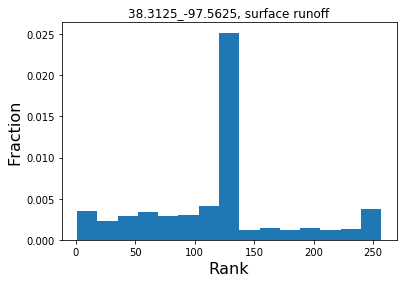

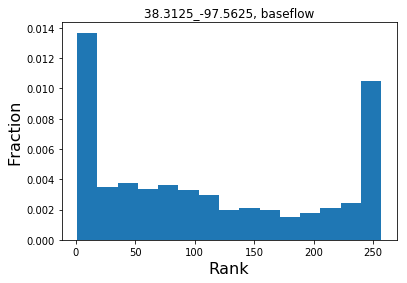

In [42]:
# --- Rank histogram (daily) --- #
# Surface runoff
true_ranks = calculate_rank_for_histogram(
    ds_cell_daily['OUT_RUNOFF'], ds_truth_cell_daily['OUT_RUNOFF'].squeeze().to_series())
fig = plt.figure()
plt.hist(true_ranks, bins=15, normed=True)
plt.xlabel('Rank', fontsize=16)
plt.ylabel('Fraction', fontsize=16)
plt.title('{}_{}, surface runoff'.format(lat, lon))
fig.savefig(os.path.join(output_ts_dir, '{}_{}.rankhist.runoff.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)
# Baseflow
true_ranks = calculate_rank_for_histogram(
    ds_cell_daily['OUT_BASEFLOW'], ds_truth_cell_daily['OUT_BASEFLOW'].squeeze().to_series())
fig = plt.figure()
plt.hist(true_ranks, bins=15, normed=True)
plt.xlabel('Rank', fontsize=16)
plt.ylabel('Fraction', fontsize=16)
plt.title('{}_{}, baseflow'.format(lat, lon))
fig.savefig(os.path.join(output_ts_dir, '{}_{}.rankhist.baseflow.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)

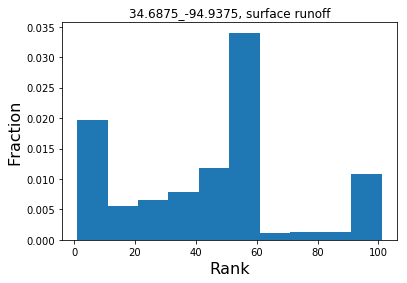

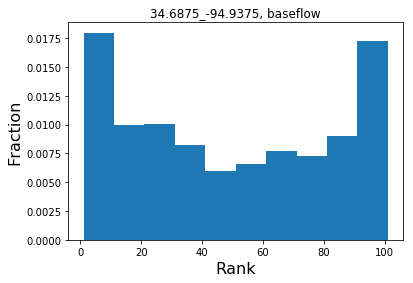

In [25]:
##### Test - only 10 states and 10 prec #####
# --- Rank histogram (daily) --- #
# Surface runoff
true_ranks = calculate_rank_for_histogram(
    ds_cell_daily_small['OUT_RUNOFF'], ds_truth_cell_daily['OUT_RUNOFF'].squeeze().to_series())
fig = plt.figure()
plt.hist(true_ranks, bins=10, normed=True)
plt.xlabel('Rank', fontsize=16)
plt.ylabel('Fraction', fontsize=16)
plt.title('{}_{}, surface runoff'.format(lat, lon))
fig.savefig(os.path.join(output_ts_dir, '{}_{}.rankhist.runoff.10state10prec.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)
# Baseflow
true_ranks = calculate_rank_for_histogram(
    ds_cell_daily_small['OUT_BASEFLOW'], ds_truth_cell_daily['OUT_BASEFLOW'].squeeze().to_series())
fig = plt.figure()
plt.hist(true_ranks, bins=10, normed=True)
plt.xlabel('Rank', fontsize=16)
plt.ylabel('Fraction', fontsize=16)
plt.title('{}_{}, baseflow'.format(lat, lon))
fig.savefig(os.path.join(output_ts_dir, '{}_{}.rankhist.baseflow.10state10prec.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)

In [ ]:
def calculate_CRPS(da_ens_data, ts_true_data):
    ''' Calculate temporal-mean CRPS
    '''

In [41]:
def calculate_rank_for_histogram(da_ens_data, ts_true_data):
    ''' Calculate rank of true value at every time step; this is for the purpose
        of plotting rank histogram.
    
    Parameters
    ----------
    da_ens_data: <xr.DataArray>
        Ensemble time series.
        Dimension: time, ensemble
    ts_true: <pd.Sereis>
        Time series of true (or observed) data
    
    Return
    ----------
    true_ranks: <np.array>
        An array of ranks (one rank value for each timestep)
    '''
    
    # Put all ensemble members and the truth in a df
    df_ens_daily = pd.DataFrame(data=da_ens_data.values,
                                index=da_ens_data['time'].values,
                                columns=da_ens_data['ensemble'].values)
    df_ens_daily['truth'] = ts_true_data.values
    # Calculate rank of true value for each timestep
    true_ranks = np.asarray([int(int(rankdata(df_ens_daily.loc[t])[-1])) for t in df_ens_daily.index])
    
    return true_ranks

'force_ens16.state_ens32'

# Plot time series

In [43]:
# ======================================================== #
# Plot setting
# ======================================================== #
cmap = matplotlib.cm.get_cmap('Spectral')

In [50]:
# ======================================================== #
# Plot surface runoff, daily
# ======================================================== #
# --- Interactive plot, zoomed in --- #
output_file(os.path.join(output_ts_dir, '{}_{}.runoffDaily.zoomin.html'.format(lat, lon)))
p = figure(title='Surface runoff, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Surface runoff (mm/day)",
           x_axis_type='datetime', width=1000, height=500)
# post-processed ensemble
for key in ds_cell_daily['ensemble'].values:
    ts = ds_cell_daily['OUT_RUNOFF'].sel(
        ensemble=key,
        time=slice(zoomin_start_time, zoomin_end_time)).to_series()
    p.line(ts.index, ts.values, color="blue", line_dash="solid", alpha=0.1,
           legend="DA post-processed ensemble\n(10-year ens. mean logRMSE={:.2f})".format(
               float(da_rmseLog_dailyRunoff_ensMean.squeeze().values)),
           line_width=2)
# plot open-loop
ts = ds_openloop_cell_daily.squeeze()['OUT_RUNOFF'].sel(time=slice(zoomin_start_time, zoomin_end_time)).to_series()
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop (10-year logRMSE={:.2f})".format(
           float(da_rmseLog_dailyRunoff_openloop.squeeze().values)),
       line_width=2)
# plot truth
ts = ds_truth_cell_daily.squeeze()['OUT_RUNOFF'].sel(time=slice(zoomin_start_time, zoomin_end_time)).to_series()
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=2)
# Save
save(p)

'/civil/hydro/ymao/data_assim/tools/plot_analyze_results/output/20180331.small_basins.synthetic/arkansas/sm_0.5.R_9.prec_0.3/postprocess/time_series/38.3125_-97.5625.runoffDaily.zoomin.html'

In [45]:
# --- Interactive plot, zoomed in, different color for each precip ensemble member --- #
list_color = [cmap(i/N_prec) for i in range(N_prec)]
output_file(os.path.join(output_ts_dir, '{}_{}.runoffDaily.zoomin.colored_each_prec.html'.format(lat, lon)))
p = figure(title='Surface runoff, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Surface runoff (mm/day)",
           x_axis_type='datetime', width=1000, height=500)
# plot open-loop
ts = ds_openloop_cell_daily.squeeze()['OUT_RUNOFF'].sel(time=slice(zoomin_start_time, zoomin_end_time)).to_series()
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=3)
# plot truth
ts = ds_truth_cell_daily.squeeze()['OUT_RUNOFF'].sel(time=slice(zoomin_start_time, zoomin_end_time)).to_series()
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=3)
# post-processed ensemble
dict_cell_ts_runoff = {}
for i in range(N_prec):
    for j in range(N_state):
        key = 'force_ens{}.state_ens{}'.format(i+1, j+1)
        ts = ds_cell_daily['OUT_RUNOFF'].sel(
            ensemble=key,
            time=slice(zoomin_start_time, zoomin_end_time)).to_series()
        p.line(ts.index, ts.values,
               color="#%02x%02x%02x" % (int(list_color[i][0]*255),
                                        int(list_color[i][1]*255),
                                        int(list_color[i][2]*255)),
               line_dash="solid", alpha=0.1,
               legend="DA post-processed ensemble", line_width=2)
# Save
save(p)

'/civil/hydro/ymao/data_assim/tools/plot_analyze_results/output/20180331.small_basins.synthetic/arkansas/sm_0.5.R_9.prec_0.3/postprocess/time_series/38.3125_-97.5625.runoffDaily.zoomin.colored_each_prec.html'

In [46]:
# --- Interactive plot, zoomed in, different color for each state ensemble member --- #
list_color = [cmap(i/N_state) for i in range(N_state)]
output_file(os.path.join(output_ts_dir, '{}_{}.runoffDaily.zoomin.colored_each_state.html'.format(lat, lon)))
p = figure(title='Surface runoff, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Surface runoff (mm/day)",
           x_axis_type='datetime', width=1000, height=500)
# plot open-loop
ts = ds_openloop_cell_daily.squeeze()['OUT_RUNOFF'].sel(time=slice(zoomin_start_time, zoomin_end_time)).to_series()
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=3)
# plot truth
ts = ds_truth_cell_daily.squeeze()['OUT_RUNOFF'].sel(time=slice(zoomin_start_time, zoomin_end_time)).to_series()
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=3)
# post-processed ensemble
dict_cell_ts_runoff = {}
for i in range(N_prec):
    for j in range(N_state):
        key = 'force_ens{}.state_ens{}'.format(i+1, j+1)
        ts = ds_cell_daily['OUT_RUNOFF'].sel(
            ensemble=key,
            time=slice(zoomin_start_time, zoomin_end_time)).to_series()
        p.line(ts.index, ts.values,
               color="#%02x%02x%02x" % (int(list_color[j][0]*255),
                                        int(list_color[j][1]*255),
                                        int(list_color[j][2]*255)),
               line_dash="solid", alpha=0.1,
               legend="DA post-processed ensemble", line_width=2)
# Save
save(p)

'/civil/hydro/ymao/data_assim/tools/plot_analyze_results/output/20180331.small_basins.synthetic/arkansas/sm_0.5.R_9.prec_0.3/postprocess/time_series/38.3125_-97.5625.runoffDaily.zoomin.colored_each_state.html'

In [51]:
# ======================================================== #
# Plot baseflow
# ======================================================== #
# --- Interactive plot, zoomed in --- #
output_file(os.path.join(output_ts_dir, '{}_{}.baseflowDaily.zoomin.html'.format(lat, lon)))
p = figure(title='Baseflow, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Baseflow (mm/day)",
           x_axis_type='datetime', width=1000, height=500)
# post-processed ensemble
dict_cell_ts_runoff = {}
for key in ds_cell_daily['ensemble'].values:
    ts = ds_cell_daily['OUT_BASEFLOW'].sel(
        ensemble=key,
        time=slice(zoomin_start_time, zoomin_end_time)).to_series()
    p.line(ts.index, ts.values, color="blue", line_dash="solid", alpha=0.1,
           legend="DA post-processed ensemble (10-year ens. mean logRMSE={:.2f})".format(
               float(da_rmseLog_dailyBaseflow_ensMean.squeeze().values)),
           line_width=2)
# plot open-loop
ts = ds_openloop_cell_daily.squeeze()['OUT_BASEFLOW'].sel(time=slice(zoomin_start_time, zoomin_end_time)).to_series()
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop (10-year logRMSE={:.2f})".format(
           float(da_rmseLog_dailyBaseflow_openloop.squeeze().values)),
       line_width=2)
# plot truth
ts = ds_truth_cell_daily.squeeze()['OUT_BASEFLOW'].sel(time=slice(zoomin_start_time, zoomin_end_time)).to_series()
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=2)
# Save
save(p)

'/civil/hydro/ymao/data_assim/tools/plot_analyze_results/output/20180331.small_basins.synthetic/arkansas/sm_0.5.R_9.prec_0.3/postprocess/time_series/38.3125_-97.5625.baseflowDaily.zoomin.html'

In [48]:
# --- Interactive plot, zoomed in, different color for each precip ensemble member --- #
list_color = [cmap(i/N_prec) for i in range(N_prec)]
output_file(os.path.join(output_ts_dir, '{}_{}.baseflowDaily.zoomin.colored_each_prec.html'.format(lat, lon)))
p = figure(title='Surface runoff, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Baseflow (mm/day)",
           x_axis_type='datetime', width=1000, height=500)
# plot open-loop
ts = ds_openloop_cell_daily.squeeze()['OUT_BASEFLOW'].sel(time=slice(zoomin_start_time, zoomin_end_time)).to_series()
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=3)
# plot truth
ts = ds_truth_cell_daily.squeeze()['OUT_BASEFLOW'].sel(time=slice(zoomin_start_time, zoomin_end_time)).to_series()
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=3)
# post-processed ensemble
dict_cell_ts_runoff = {}
for i in range(N_prec):
    for j in range(N_state):
        key = 'force_ens{}.state_ens{}'.format(i+1, j+1)
        ts = ds_cell_daily['OUT_BASEFLOW'].sel(
            ensemble=key,
            time=slice(zoomin_start_time, zoomin_end_time)).to_series()
        p.line(ts.index, ts.values,
               color="#%02x%02x%02x" % (int(list_color[i][0]*255),
                                        int(list_color[i][1]*255),
                                        int(list_color[i][2]*255)),
               line_dash="solid", alpha=0.1,
               legend="DA post-processed ensemble", line_width=2)
# Save
save(p)

'/civil/hydro/ymao/data_assim/tools/plot_analyze_results/output/20180331.small_basins.synthetic/arkansas/sm_0.5.R_9.prec_0.3/postprocess/time_series/38.3125_-97.5625.baseflowDaily.zoomin.colored_each_prec.html'

In [49]:
# --- Interactive plot, zoomed in, different color for each state ensemble member --- #
list_color = [cmap(i/N_state) for i in range(N_state)]
output_file(os.path.join(output_ts_dir, '{}_{}.baseflowDaily.zoomin.colored_each_state.html'.format(lat, lon)))
p = figure(title='Surface runoff, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Baseflow (mm/day)",
           x_axis_type='datetime', width=1000, height=500)
# plot open-loop
ts = ds_openloop_cell_daily.squeeze()['OUT_BASEFLOW'].sel(time=slice(zoomin_start_time, zoomin_end_time)).to_series()
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=3)
# plot truth
ts = ds_truth_cell_daily.squeeze()['OUT_BASEFLOW'].sel(time=slice(zoomin_start_time, zoomin_end_time)).to_series()
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=3)
# post-processed ensemble
dict_cell_ts_runoff = {}
for i in range(N_prec):
    for j in range(N_state):
        key = 'force_ens{}.state_ens{}'.format(i+1, j+1)
        ts = ds_cell_daily['OUT_BASEFLOW'].sel(
            ensemble=key,
            time=slice(zoomin_start_time, zoomin_end_time)).to_series()
        p.line(ts.index, ts.values,
               color="#%02x%02x%02x" % (int(list_color[j][0]*255),
                                        int(list_color[j][1]*255),
                                        int(list_color[j][2]*255)),
               line_dash="solid", alpha=0.1,
               legend="DA post-processed ensemble", line_width=2)
# Save
save(p)

'/civil/hydro/ymao/data_assim/tools/plot_analyze_results/output/20180331.small_basins.synthetic/arkansas/sm_0.5.R_9.prec_0.3/postprocess/time_series/38.3125_-97.5625.baseflowDaily.zoomin.colored_each_state.html'